# Analysis Project Demonstration

## Import data from Spreadsheet Template, convert data from the spreedsheet into a YML, and run `pycap`

This demonstration starts with a spreadsheet template, reads it in, populates a nested dictionary, writes a `yml` file that the `AnalysisProject` class can read in, then executes the `AnalysisProject` functionality. 

This notebook doesn't explain all functionality in the `AnalysisProject` class, but rather shows this example of how multiple `Well` objects and responses can be combined into a more comprehensive project representing all wells and responses in an area.


##### Libraries you will need to run this script

In [1]:
import yaml
import pandas as pd
from pathlib import Path

### Path to your .xlsx template spreadsheet
##### Also provide a name for the PyCap run

In [2]:
pycap_inputs_excel = "./test_run.xlsx"
pycap_run_name = "TestExample"

### Convert the Excel tabs into dataframes

In [3]:
raw_global = pd.read_excel(pycap_inputs_excel, sheet_name="Global_Inputs")
raw_hcw = pd.read_excel(pycap_inputs_excel, sheet_name="HCW_Inputs")
raw_dd = pd.read_excel(pycap_inputs_excel, sheet_name="Drawdown_Inputs")
raw_depl = pd.read_excel(pycap_inputs_excel, sheet_name="Depletion_Inputs")

#### Data wrangling to get Excel information readable in Python 

In [4]:
raw_hcw["HCW"] = raw_hcw["HCW"].astype(str)
raw_dd["HCW"] = raw_dd["HCW"].astype(str)
raw_depl["HCW"] = raw_depl["HCW"].astype(str)
raw_dd["pycap_resource_name"] = raw_dd["Resource_Name"]
raw_depl["pycap_resource_name"] = raw_depl["Resource_Name"]

raw_dd["Resource_Name"] = [i.replace(" ", "") for i in raw_dd["Resource_Name"]]
raw_dd["pycap_resource_name"] = [
    ":".join((rn, hcw)) for rn, hcw in zip(raw_dd["Resource_Name"], raw_dd["HCW"])
]

raw_depl["Resource_Name"] = [i.replace(" ", "") for i in raw_depl["Resource_Name"]]
raw_depl["pycap_resource_name"] = [
    ":".join((rn, hcw)) for rn, hcw in zip(raw_depl["Resource_Name"], raw_depl["HCW"])
]

#### Create nested dictionaries of inputs for YML

##### Project data, with default data for T, S, t, etc

In [5]:
project_dict = dict()
project_dict["project_properties"] = {
    "name": pycap_run_name,
    "T": float(raw_global["Transmissivity_ft2d"][0]),
    "S": float(raw_global["Storage_Coeff"][0]),
    "default_dd_days": float(raw_global["Default_dd_days"][0]),
    "default_depletion_years": float(raw_global["Default_depletion_years"].values[0]),
    "default_pumping_days": float(raw_global["Default_pumping_days"].values[0]),
}

##### Well data, with apportionment, and name of location impacts will be assessed

In [6]:
raw_depl

,Resource_Type,Resource_Name,Resource_Lat,Resource_Long,Fraction_Intercept,HCW,Comments,pycap_resource_name
0,Stream,TomorrowRiver,44.623796,89.403412,0.705013,14,NaN,TomorrowRiver:14
1,Stream,TomorrowRiver,44.623796,89.403412,0.816983,137,NaN,TomorrowRiver:137
2,Stream,TomorrowRiver,44.623796,89.403412,0.738771,58,NaN,TomorrowRiver:58
3,Stream,TomorrowRiver,44.623796,89.403412,0.699034,98,NaN,TomorrowRiver:98
4,Stream,TomorrowRiver,44.623796,89.403412,0.670640,142,NaN,TomorrowRiver:142
...,...,...,...,...,...,...,...,...
199,Stream,TomorrowRiver,44.376763,89.235707,0.640469,117,NaN,TomorrowRiver:117
200,Stream,TomorrowRiver,44.376763,89.235707,0.460920,54,NaN,TomorrowRiver:54
201,Stream,TomorrowRiver,44.382820,89.228899,0.486513,62,NaN,TomorrowRiver:62
202,Stream,TomorrowRiver,44.382824,89.226047,0.822763,27,NaN,TomorrowRiver:27


In [7]:
stream_dict = {
    i: {
        "HCW": hcw,
        "stream_apportionment": {
            "name": pycap_resource_name,
            "apportionment": float(frac_intercept),
        },
    }
    for i, hcw, pycap_resource_name, frac_intercept in zip(
        range(len(raw_depl)),
        raw_depl["HCW"],
        raw_depl["pycap_resource_name"],
        raw_depl["Fraction_Intercept"],
    )
}

In [8]:
well_dict = {
    i: {
        "name": hcw,
        "status": well_stat.lower(),
        "loc": {
            "x": float(well_long),
            "y": float(well_lat),
        },
        "Q": float(Q_gpm),
        "pumping_days": int(pump_days),
    }
    for i, hcw, well_stat, well_long, well_lat, Q_gpm, pump_days in zip(
        range(len(raw_hcw)),
        raw_hcw["HCW"],
        raw_hcw["Well_Status"],
        raw_hcw["Well_Long"],
        raw_hcw["Well_Lat"],
        raw_hcw["Q_gpm"],
        raw_hcw["Pumping_Days"],
    )
}

In [9]:
stream_dict_df = pd.DataFrame.from_dict(stream_dict, orient="index")
stream_dict_df = stream_dict_df.rename("stream_apportionment{}".format)

In [10]:
# rekey the well_dict dictionary using the names
well_dict = {i["name"]: i for _, i in well_dict.items()}

In [11]:
if len(raw_depl["HCW"]) > 0:
    # bring in the stream apportionment values
    for j in well_dict:
        well_dict[j].update(
            stream_dict_df.loc[stream_dict_df["HCW"] == j]["stream_apportionment"]
        )

# bring in the stream and drawdown response information
for j in well_dict:
    well_dict[j].update(
        {
            "stream_response": (
                list(raw_depl.loc[raw_depl["HCW"] == j]["pycap_resource_name"])
            )
        }
    )
    well_dict[j].update(
        {"dd_response": (list(raw_dd.loc[raw_dd["HCW"] == j]["Resource_Name"]))}
    )

# rename the keys again
well_dict = {f"well_{k}": v for k, v in well_dict.items()}

##### Stream Response Locations

In [12]:
streamresp_dict = {
    f"stream_response{i}": {
        "name": pycap_resource_name,
        "loc": {
            "x": float(res_long),
            "y": float(res_lat),
        },
    }
    for i, pycap_resource_name, res_long, res_lat in zip(
        range(len(raw_depl)),
        raw_depl["pycap_resource_name"],
        raw_depl["Resource_Long"],
        raw_depl["Resource_Lat"],
    )
}

##### Drawdown Response Locations

In [13]:
raw_dd_unique = raw_dd.drop_duplicates(subset=["Resource_Name"]).reset_index()

ddresp_dict = {
    f"dd_response{i}": {
        "name": ResName,
        "loc": {
            "x": float(res_long),
            "y": float(res_lat),
        },
    }
    for i, ResName, res_long, res_lat in zip(
        range(len(raw_dd_unique)),
        raw_dd_unique["Resource_Name"],
        raw_dd_unique["Resource_Long"],
        raw_dd_unique["Resource_Lat"],
    )
}

#### Combine all the above dictionaries and save as a yml

In [14]:
combdict = {**project_dict, **well_dict, **ddresp_dict, **streamresp_dict}
yml_name = pycap_run_name + ".yml"

with open(yml_name, "w") as file:
    documents = yaml.dump(combdict, file, default_flow_style=False, sort_keys=False)

## Run `pycap` with existing YML file

##### Libraries you'll need to run this script

In [15]:
import sys

sys.path.insert(1, "../../")
from pycap.analysis_project import Project

### Path to the folder and the name of the .yml file you've created.

In [16]:
datapath = Path("")
yml_file = "TestExample.yml"

### Call `pycap.analysis_project` to run Python tool

In [17]:
ap = Project(datapath / yml_file)
ap.report_responses()
ap.write_responses_csv()

Writing report to TestExample.yml.import_report



Successfully parsed TestExample.yml (high five!)
*************************
Summary follows:

WELLS:
203 existing wells:
	1
	2
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
	30
	31
	32
	33
	34
	35
	36
	37
	38
	39
	40
	41
	42
	43
	44
	45
	46
	47
	48
	49
	50
	51
	52
	53
	54
	55
	56
	57
	58
	59
	60
	61
	62
	63
	64
	65
	66
	67
	68
	69
	70
	71
	72
	73
	74
	75
	76
	77
	78
	79
	80
	81
	82
	83
	84
	85
	86
	87
	88
	89
	90
	91
	92
	93
	94
	95
	96
	97
	98
	99
	100
	101
	102
	103
	104
	105
	106
	107
	108
	109
	110
	111
	112
	113
	114
	115
	116
	117
	118
	119
	120
	121
	122
	123
	124
	125
	126
	127
	128
	129
	130
	131
	132
	133
	134
	135
	136
	137
	138
	139
	140
	141
	142
	143
	144
	145
	146
	147
	148
	149
	150
	151
	152
	153
	154
	155
	156
	157
	158
	159
	160
	161
	162
	163
	164
	165
	166
	167
	168
	169
	170
	171
	172
	173
	174
	175
	176
	177
	178
	179
	180
	181
	182
	183
	184
	185
	186
	187
	188


### Now Let's have a look at the main results files

#### First, the summary base depletion

In [18]:
# first the summary, base depletion
depl = pd.read_csv(
    "output/TestExample.table_report.base_stream_depletion.csv", index_col=0
)
depl

,TomorrowRiver
3,0.072980
1,0.009860
2,0.008878
4,0.042601
5,0.477394
...,...
203,0.000000
204,0.000000
total_proposed,0.072980
total_existing,2.974664


#### Combined report of all depletion and drawdown calculations

In [19]:
tab_report = pd.read_csv("output/TestExample.table_report.csv", index_col=0)
tab_report

,LakeEmily:dd (ft),TomorrowRiver:1:depl (cfs),TomorrowRiver:2:depl (cfs),TomorrowRiver:4:depl (cfs),TomorrowRiver:5:depl (cfs),TomorrowRiver:6:depl (cfs),TomorrowRiver:7:depl (cfs),TomorrowRiver:8:depl (cfs),TomorrowRiver:9:depl (cfs),TomorrowRiver:10:depl (cfs),...,TomorrowRiver:196:depl (cfs),TomorrowRiver:197:depl (cfs),TomorrowRiver:198:depl (cfs),TomorrowRiver:199:depl (cfs),TomorrowRiver:200:depl (cfs),TomorrowRiver:201:depl (cfs),TomorrowRiver:202:depl (cfs),TomorrowRiver:203:depl (cfs),TomorrowRiver:204:depl (cfs),TomorrowRiver:3:depl (cfs)
3: proposed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07298
1: existing,0.000048,0.00986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2: existing,NaN,NaN,0.008878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4: existing,NaN,NaN,NaN,0.042601,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5: existing,NaN,NaN,NaN,NaN,0.477394,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203: existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
204: existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
total_proposed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07298
total_existing,0.000048,0.00986,0.008878,0.042601,0.477394,0.038422,0.049016,0.022823,0.160571,0.035432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


#### All the depletion time series are included in a single time series

<Axes: >

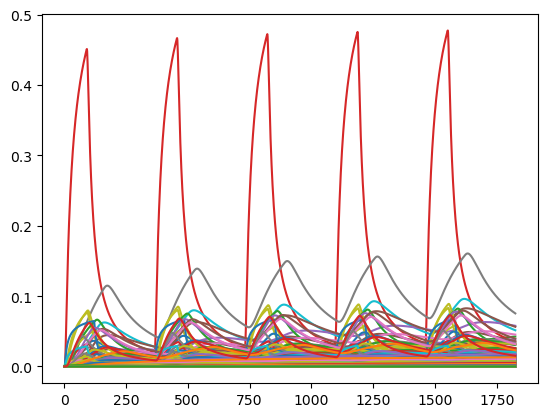

In [20]:
all_time_series = pd.read_csv("output/TestExample.table_report.all_ts.csv", index_col=0)
all_time_series.plot(legend=None)